In [1]:
import torch
import matplotlib.pyplot as plt
import warnings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Exact diagonalization

The potential is $V(x) = V_0 \sin^2(k_1 x)$, with period $k_1 x= 2\pi n\to x = \frac{2\pi}{k_1}n$. This means the hamiltonian is:

$$H = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}+V_0 \sin^2(k_1 x)$$

To construct the exact diagonalization, we use the usual finite differences for the kinetic term:

$$K\psi = -\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}\psi\approx -\frac{\hbar^2}{2m}\frac{\psi_{i-1}-2\psi_i+\psi_{i+1}}{h^2}$$

Where we discretized $\psi(x)\to \psi(x_i)\equiv\psi_i$ in an equispaced grid with spacing $h\equiv x_{i}-x_{i-1}$. Expressing psi as a vector such as:

$$\psi = \begin{pmatrix}\psi_1\\\psi_2\\\vdots\\\psi_N\end{pmatrix}$$

We see that the kinetic operator can be expressed as a tridiagonal matrix:

$$K = -\frac{\hbar^2}{2mh^2}(-2\delta_{i,j}+\delta_{i, j+1}+\delta_{i, j-1})=-\frac{\hbar^2}{2mh^2}\begin{pmatrix}-2&1&0&\dots&0\\1&-2&1&\dots&0\\0&1&-2&\dots&0\\\vdots&\vdots&\vdots&\ddots&1\\0&0&0&\dots&-2\end{pmatrix}$$

## Boundary conditions

If PBC, then at positions [0,-1] and [-1,0] there has to be a 1.

In [49]:
# PARAMETERS
HBAR = 1.0
MASS = 1.0
V0 = 0.1
K1 = 1.0
PBC = True

N_POINTS = 5_000
N_PERIODS_FROM_CENTRE_TO_RIGHT = 2 # number of periods from the center to the right edge
# A = 2*N_PERIODS_FROM_CENTRE_TO_RIGHT-1 # number of periods in the box centered at zero
A = N_PERIODS_FROM_CENTRE_TO_RIGHT
L_BOX = 2*torch.pi/K1 * A
GRID_SPACING = L_BOX / N_POINTS
# if GRID_SPACING < torch.pi/(K1):
#     warnings.warn("Aliasing may occur: N_POINTS is too small for the given K1.")

# Create a grid of points
x = torch.linspace(-L_BOX/2,L_BOX/2, N_POINTS).to(device)

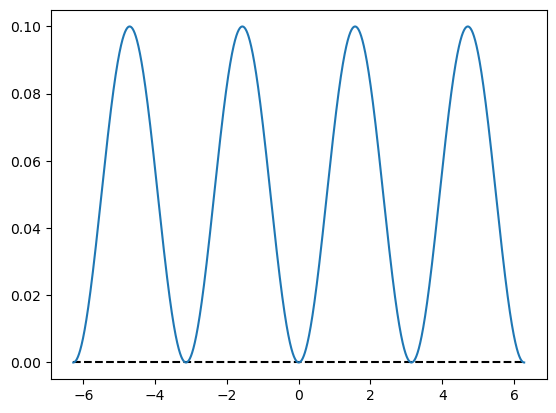

In [50]:
def V(x):
    """Potential function."""
    return V0 * torch.sin(K1 * x).pow(2)

plt.hlines(0, -L_BOX/2, L_BOX/2, colors='black', linestyles='dashed')
plt.plot(x.cpu().numpy(), V(x).cpu().numpy(), label='Potential V(x)')

In [51]:
def hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC):
    kin_coeff = HBAR**2 / (2 * MASS * GRID_SPACING**2)
    kin_main_diag = 2*torch.ones(N_POINTS, device=device)  # Main diagonal for kinetic energy
    kin_off_diags = -1*torch.ones(N_POINTS-1, device=device)  # Off-diagonal elements for kinetic energy
    # kin_matrix = torch.zeros((N_POINTS, N_POINTS))
    kin_matrix = torch.diag(kin_main_diag).to(device)
    kin_matrix += torch.diag(kin_off_diags, diagonal=1)
    kin_matrix += torch.diag(kin_off_diags, diagonal=-1)
    if PBC:
        kin_matrix[0, -1] = 1
        kin_matrix[-1, 0] = 1
    pot_matrix = torch.zeros((N_POINTS, N_POINTS), device=device)
    for i in range(N_POINTS):
        pot_matrix[i, i] = V(x[i])
        # TO TRY HARMONIC POTENTIAL COMMENT OUT ABOVE LINE AND UNCOMMENT BELOW
        # pot_matrix[i, i] = 0.5*MASS* x[i]**2  # Harmonic potential
    return kin_coeff * kin_matrix + pot_matrix

In [52]:
eigenvalues, eigenstates = torch.linalg.eigh(hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC), )
print(eigenstates.shape)

for i in range(5):
    print(f'Eigenvalue {i}: {eigenvalues[i].item()}')

torch.Size([5000, 5000])
Eigenvalue 0: 0.07854245603084564
Eigenvalue 1: 0.09711866825819016
Eigenvalue 2: 0.29361894726753235
Eigenvalue 3: 0.33254024386405945
Eigenvalue 4: 0.7868294715881348


In [53]:
n_periods_range = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

ground_state_energy = []
first_excited_state_energy = []
second_excited_state_energy = []
third_excited_state_energy = []
eigstate_histories = []

for i in range(14,22):
    N_PERIODS_FROM_CENTRE_TO_RIGHT = i # number of periods from the center to the right edge
    # A = 2*N_PERIODS_FROM_CENTRE_TO_RIGHT-1 # number of periods in the box centered at zero
    A = N_PERIODS_FROM_CENTRE_TO_RIGHT
    L_BOX = 2*torch.pi/K1 * A
    GRID_SPACING = L_BOX / N_POINTS
    x = torch.linspace(-L_BOX/2,L_BOX/2, N_POINTS).to(device)
    hamiltonian = hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC)
    eigenvalues, eigenstates = torch.linalg.eigh(hamiltonian)
    ground_state_energy.append(eigenvalues[0].item()) 
    first_excited_state_energy.append(eigenvalues[1].item())
    second_excited_state_energy.append(eigenvalues[2].item())
    third_excited_state_energy.append(eigenvalues[3].item())
    norm = torch.trapz(eigenstates[:, 0]**2, x=x)
    eigenstates[:, 0] /= torch.sqrt(norm)  # Normalize the ground state
    eigstate_histories.append(eigenstates[:, 0].cpu().numpy())
    print(f'Norm of ground state for {i} periods: {norm.item()}')

Norm of ground state for 14 periods: 0.017584040760993958
Norm of ground state for 15 periods: 0.018853310495615005
Norm of ground state for 16 periods: 0.020105790346860886
Norm of ground state for 17 periods: 0.021367095410823822
Norm of ground state for 18 periods: 0.02262396551668644
Norm of ground state for 19 periods: 0.023880833759903908
Norm of ground state for 20 periods: 0.025137759745121002
Norm of ground state for 21 periods: 0.026394644752144814


[]


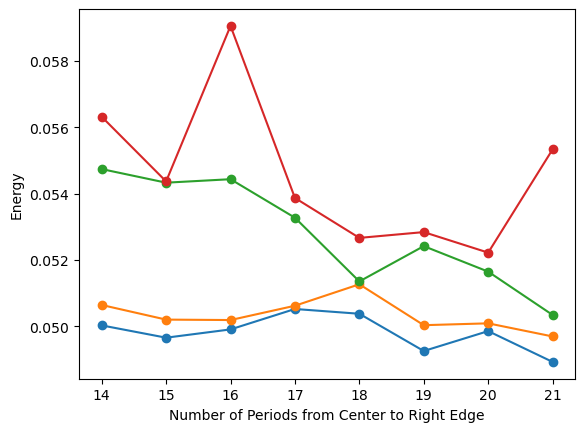

In [54]:
n_periods_range = list(range(14,22))
plt.plot(n_periods_range, ground_state_energy, marker='o', label='Ground State Energy')
plt.plot(n_periods_range, first_excited_state_energy, marker='o', label='First Excited State Energy')
plt.plot(n_periods_range, second_excited_state_energy, marker='o', label='Second Excited State Energy')
plt.plot(n_periods_range, third_excited_state_energy, marker='o', label='Third Excited State Energy')
# plt.xlim(18,21)
# plt.semilogy()
plt.xlabel('Number of Periods from Center to Right Edge')
plt.ylabel('Energy')
print(ground_state_energy[9:12])

In [60]:
print(L_BOX)

131.94689145077132


Text(0, 0.5, 'Eigenstate')

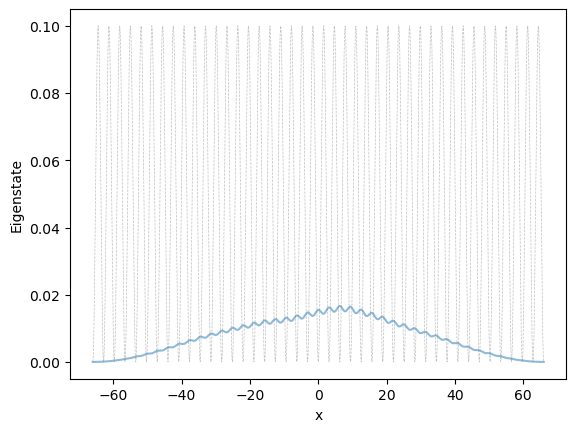

In [69]:
# for eigstate in eigstate_histories[-2:-1]:
plt.plot(x.cpu().numpy(), eigstate_histories[-1]**2, alpha=0.5)
plt.plot(x.cpu().numpy(), V(x).cpu().numpy(), label='Potential V(x)', color='gray', linestyle='dashed', alpha=0.5, linewidth=0.5)
plt.xlabel('x')
plt.ylabel('Eigenstate')

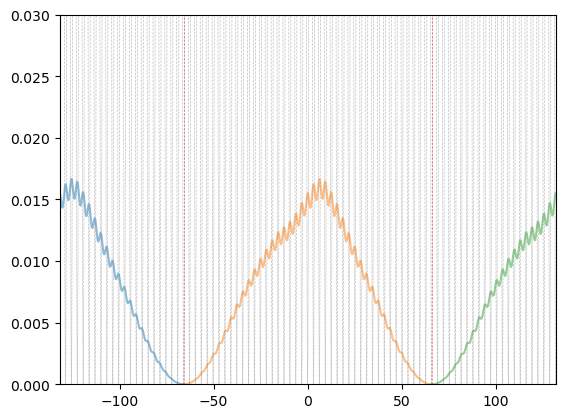

In [90]:
for shift in [-L_BOX, 0, L_BOX]:
    plt.plot(x.cpu().numpy() + shift, eigstate_histories[-1]**2, alpha=0.5)
    plt.plot(x.cpu().numpy() + shift, V(x).cpu().numpy(), label='Potential V(x)', color='gray', linestyle='dashed', alpha=0.5, linewidth=0.5)
plt.xlim(-L_BOX, L_BOX)
plt.vlines([-L_BOX/2, L_BOX/2], 0, V0, colors='red', linestyles='dashed', alpha=0.5, linewidth=0.5) 
plt.ylim(0, 0.03)
plt.savefig('eigenstate_plot.png', dpi=300)


# Variational approach

In [43]:
import qvarnet
from qvarnet.models.mlp import MLP

In [44]:
N_PERIODS_FROM_CENTRE_TO_RIGHT = i # number of periods from the center to the right edge
A = N_PERIODS_FROM_CENTRE_TO_RIGHT
L_BOX = 2*torch.pi/K1 * A
GRID_SPACING = L_BOX / N_POINTS
x = torch.linspace(-L_BOX/2,L_BOX/2, N_POINTS)

import copy

class EarlyStoppingCallback:
    def __init__(self, patience=10, min_delta=1e-5):
        self.patience = patience
        self.min_delta = min_delta
        self.best_energy = None
        self.best_model_state = None
        self.epochs_without_improvement = 0
        self.stop_training = False

    def __call__(self, epoch, energy, model):
        # Initialize the best energy if it's the first epoch
        if self.best_energy is None:
            self.best_energy = energy
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.epochs_without_improvement = 0
        else:
            # Check if the energy has improved by more than min_delta
            if energy < (self.best_energy - self.min_delta):
                self.best_energy = energy
                self.best_model_state = copy.deepcopy(model.state_dict())
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        # If there is no improvement for the specified patience, stop training
        if self.epochs_without_improvement >= self.patience:
            print(f"Stopping training after {epoch+1} epochs due to no improvement in energy.")
            self.stop_training = True

In [45]:
def kinetic_energy(psi, x):
    # First derivative
    dpsi_dx = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi),
                                  create_graph=True, retain_graph=True)[0]
    # Second derivative
    d2psi_dx2 = torch.autograd.grad(dpsi_dx, x, grad_outputs=torch.ones_like(dpsi_dx),
                                    create_graph=True, retain_graph=True)[0]
    return -0.5 * d2psi_dx2

In [46]:
epochs = 50_000

Nh=100

model = MLP(layer_dims=[1, Nh, 1], activation="tanh")
model.to(device)

# init weights
for param in model.parameters():
    if len(param.shape) > 1:  # only initialize weights, not biases
        torch.nn.init.xavier_uniform_(param)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

x_train = torch.linspace(-L_BOX/2, L_BOX/2, 10000).view(-1, 1).to(device)
x_train.requires_grad = True

callback = EarlyStoppingCallback(patience=500, min_delta=1e-6)

print_interval = 100

for epoch in (range(epochs)):
    optimizer.zero_grad()
    # Run sampler

    psi = model(x_train) # computes forward pass
    T = kinetic_energy(psi, x_train)
    V_psi = V(x_train) * psi
    H_psi = T + V_psi

    numerator = torch.trapezoid(torch.conj(psi) * H_psi, x_train, dim=0)
    denominator = torch.trapezoid(psi.pow(2), x_train, dim=0)
    energy = numerator / denominator
    energy_copy = energy.clone().detach()
    loss = energy

    # boundary conditions
    norm_psi = torch.trapezoid(psi.pow(2), x_train, dim=0)
    psi = psi / torch.sqrt(norm_psi + 1e-8)  # normalize wavefunction
    loss += 1e6 * (psi[0] - psi[-1])**2 # penalize boundary conditions
    
    loss.squeeze().backward()
    optimizer.step()

    if epoch % print_interval == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Energy: {energy_copy.item():.4f}")

    if callback is not None:
        callback(epoch, loss, model)

        # If the callback indicates stopping, break the training loop
        if hasattr(callback, 'stop_training') and callback.stop_training:
            model.load_state_dict(callback.best_model_state)
            print(f"Training stopped early at epoch {epoch+1}")
            break
    
print(energy)
model.load_state_dict(callback.best_model_state)

Epoch 1/50000, Loss: 29901.4219, Energy: 0.0063
Epoch 101/50000, Loss: 0.3422, Energy: 0.0107
Epoch 201/50000, Loss: 0.0107, Energy: 0.0107
Epoch 301/50000, Loss: 0.0107, Energy: 0.0107
Epoch 401/50000, Loss: 0.0107, Energy: 0.0107
Epoch 501/50000, Loss: 0.0107, Energy: 0.0107
Epoch 601/50000, Loss: 0.0107, Energy: 0.0107
Stopping training after 676 epochs due to no improvement in energy.
Training stopped early at epoch 676
tensor([0.0107], device='cuda:0', grad_fn=<AddBackward0>)


<All keys matched successfully>

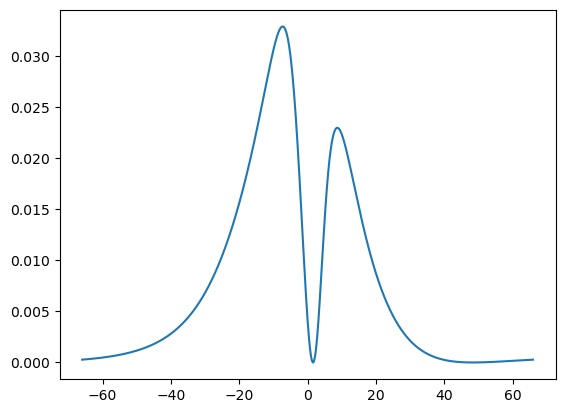

In [47]:
plt.plot(x_train.cpu().detach().numpy(), psi.detach().cpu().numpy()**2, label='Wavefunction')

ValueError: x and y must have same first dimension, but have shapes (5000,) and (10000, 1)

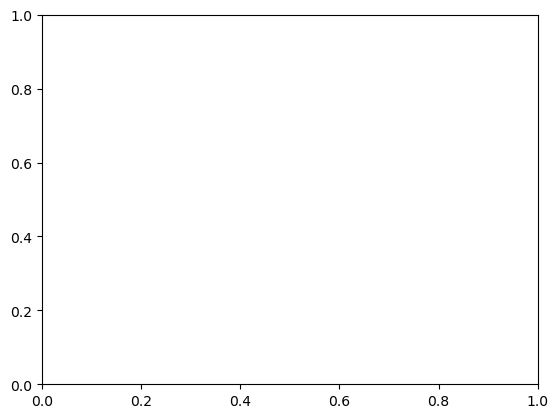

In [48]:
L = x[-1] - x[0]
for shift in [-L, 0, L]:
    plt.plot(x + shift, psi.detach().cpu().numpy()**2, '--', alpha=0.5)